This is the third in a series of notebooks designed for the "Hackathon" at the TESS Interactive Data Workshop at the 241st AAS meeting.

The hackathon notebooks are intended to be a non-comprehensive guide on to how to approach different problems with TESS. It is up to the user to fill in the blanks to customize the notebook to their interests. Because of this, a basic knowledge of TESS data handling is prerequisite to these notebooks.

If you are new to TESS, please first refer to the following tutorials before proceeding further.
MAST tutorials (also available on TIKE): https://github.com/spacetelescope/tike_content/blob/main/content/science-examples-github.md
lightkurve tutorials: https://docs.lightkurve.org/tutorials/index.html

In [2]:
%matplotlib inline

In [3]:
import numpy as np
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as unts
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import glob

In this notebook, we will take a cutout from an FFI and turn it in to a GIF you can share with all your friends on social media (or put in your slides for a conferece, whatever). This can also come in handy if you encounter some a weird feature in your lightcurve and want to see if there is some obvious explanation (was it planet 9 zipping by your target?? Maybe at least an asteroid?). Perhaps you have a transient event that you want to visualize. Whatever the case may be, turning TESS data into an GIF is pretty simple and satisfying. 

# Step 1 : Cutout your region of interest in the FFI

The first thing we will need to do is figure out what we want to make a little gif of. For our purposes, lets just pick a nice planet-hosting star and make a gif of the surrounding pixels. 

In [4]:
# Everyone's favorite exoplanet host!
starName = "HD 209458" 
# Define how big we want the cutout to be
radSearch = (5*unts.arcmin) 

In [5]:
# Search for objects within the search radius you selected.
# We really only need the target right now, but later this will be useful for overplotting other stars in the FOV
catalogData = Catalogs.query_object(starName, radius = radSearch.to('degree'), catalog = "TIC")
print("There are %s objects in this field"%len(catalogData))

ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first five rows
catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType']

There are 242 objects in this field


ID,Tmag,Jmag,ra,dec,objType
str11,float64,float64,float64,float64,str8
420814525,7.1274,6.591,330.794887332661,18.8843189579296,STAR
2000745611,20.2898,nan,330.791994069614,18.8886786047438,STAR
2000745610,20.0461,nan,330.788114803802,18.8812437457584,STAR
420814529,16.6262,15.656,330.795713313729,18.8934571085324,STAR
2000745613,16.8466,nan,330.794203282184,18.89452197659,STAR


In [6]:
# Create a list of nearby bright(ish) stars. 
bright = catalogData['Tmag'] < 18 #Note Tmag is the TESS band magnitude

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars we will plot later
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec']) )
len(nearbyStars)

114

Next let's figure out what sectors the data is available for. 

Remember, the FFI cadence changes by sector.
- Sectors 1-26 have a cadence of 30-minutes 
- Sectors 27-55 have a cadence of 10-minutes
- Sectors 56+ have a cadence of 200-seconds

In [7]:
# ra and dec come from your target search above
coord = SkyCoord(ra, dec, unit = "deg") 

sectorTable = Tesscut.get_sectors(coordinates=coord)
sectorTable

sectorName,sector,camera,ccd
str14,int64,int64,int64
tess-s0056-1-2,56,1,2


This example only has one sector of observations. This happens to be from the second extended mission, so 200-second cadence. The next step is to cut out that data.

In [10]:
#If we specify a sector, this will still be a list with one hdu object in it 
hdulist = Tesscut.get_cutouts(coordinates=coord, size=radSearch*2, sector=56)


# Step 2: Plot the cutout region


This is where we get the images ready. We will save out frames from the FFI cutout as png images. Then later we will turn those into a GIF. 

Here we will plot the TESS data. Then overtop we will plot a dot over the brightest stars in the region. To add another dimension to this, we will scale the star markers by their brightness. 

In [8]:

def plot_cutout(hdu, image_number, ra, dec, savefig=False):
    #hdu = tesscut data downloaded in the previous section
    #image_number = frame you want to plot. For 200-sec data like this there are over 11,000 frames
    #ra = Right ascension of all objects you want to plot
    #dec = Declination of all the objects you want to plot
    #savefig = optional flag to specify if you want to save the image to disk. If not it will print to screen. 
    
    
    Image = hdu[1].data['FLUX'][image_number]

    # Get the world coordinate system information from the TPF you created
    wcs = WCS(hdu[2].header)

    # plot the TPF frame
    fig = plt.figure(figsize = (8, 8))
    fig.add_subplot(111, projection = wcs)
    plt.imshow(Image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(Image, 92),
           vmin = np.percentile(Image, 5))
    
    # add grid lines to look nice
    plt.grid(axis = 'both',color = 'white', ls = 'solid')

    plt.title('%s Image %s'%(starName, image_number))
    plt.xlabel('RA', fontsize = 12)
    plt.ylabel('Dec', fontsize = 12)

    starloc = wcs.all_world2pix([[ra,dec]],0) 
    #Plot the location of the target star in red
    plt.scatter(starloc[0,0], starloc[0,1],s = (18-np.array(catalogData[bright]['Tmag'])[0])*10,color = 'red')

    # Plot nearby stars as well, which we created using our Catalog call above.
    nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
    # the size of the marker is defined as a function of the magnitude
    plt.scatter(nearbyLoc[:, 0], nearbyLoc[:, 1], 
                s =(18-np.array(catalogData[bright]['Tmag'])[1:])*10, color = 'orange')
    
    if savefig:
        MYDIR = ("GIF_images")
        CHECK_FOLDER = os.path.isdir(MYDIR)
        # If folder doesn't exist, then create it.
        if not CHECK_FOLDER:
            os.makedirs(MYDIR)

        plt.savefig(MYDIR+'/%s_%s.png'%(starName, image_number))
        plt.close()
    else:
        plt.show()
        


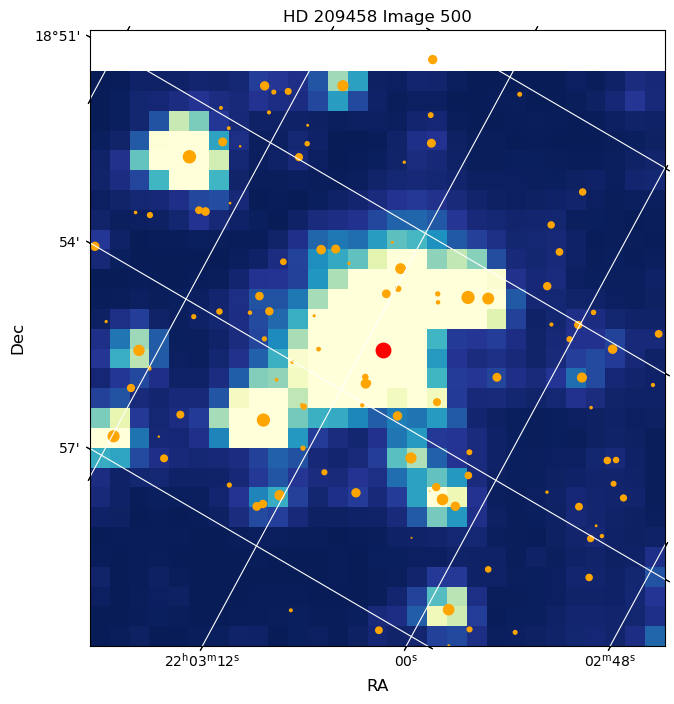

In [11]:
#test what it looks like on one image.
plot_cutout(hdulist[0], 500, ra, dec, savefig=False)

In [180]:
#This target has 200-s FFIs so there are a lot of images (11,775 to be exact). 
#To simplify this, I'll make my GIF of every 50th image

for ii in tqdm(np.arange(0, hdulist[0][1].data['TIME'].shape[0], 50)): 
    plot_cutout(hdulist[0], ii, ra, dec, savefig=True)


  0%|          | 0/236 [00:00<?, ?it/s]

# Step 3: Turn the images into a GIF

There are several different ways to turn your images into a gif. Here, we use the Pillow package. This is useful for handling images in python, has a very straightforward GIF tool, and is usable within TIKE. Winning! But that doesn't mean other tools like imageio won't work as well, I just haven't tested them in the TIKE framework. 

Check out the Pillow documentation here:
https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#saving

In [184]:
from PIL import Image
def make_gif(frame_folder):
    #Added this step to sort the filenames by the frame number in the image title. 
    filenames = sorted(glob.glob('GIF_images/*.png'), key=lambda x: int(x.split('.png')[0].split('_')[-1]))
    frames = [Image.open(image) for image in filenames]
    frame_one = frames[0]
    frame_one.save("GIF_images/%s.gif"%starName, format="GIF", append_images=frames,
               save_all=True, duration=100, loop=1) 
               #duration in milliseconds
               #loop=1 makes it stop after 1 loop (0 would play infinitely)
make_gif('GIF_images/*.jpg')

That's it! Now you can put your TESS GIFs all over the internet. 

While the process is straightforward, there are a lot of things you can do to customize the GIF. The easiest place to start is with the image creation. Play with the plotting to get the color palate, axes labels, star overlays, etc as you desire. Adding colorbars or a marker scale reference box could be useful. Maybe even adding text or an arrow to highlight an interesting feature you want to call out. The sky is the limit.

As for creating the GIF, there is slightly less variation, although you can of course change the speed of the GIF to suit your needs. One note about GIF creation is that the input image matters here (at least for pillow). GIFs have a limited color palate, and the conversion between jpg and gif is a bit rough around the edges (try it and you'll see!). That is why we have gone with png.